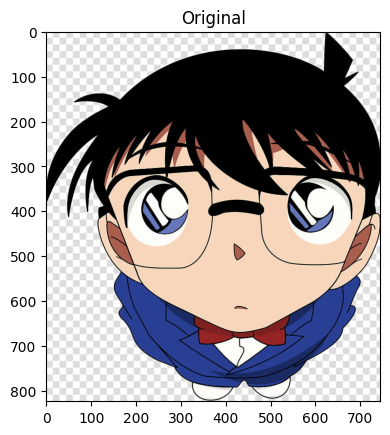

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Block size:(2,2), Time processing on GPU with shared memory: 0.28964710235595703s


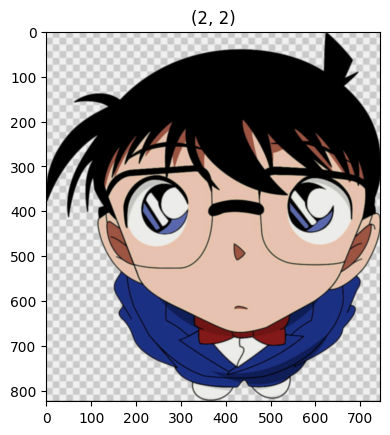

Block size:(4,4), Time processing on GPU with shared memory: 0.005957365036010742s


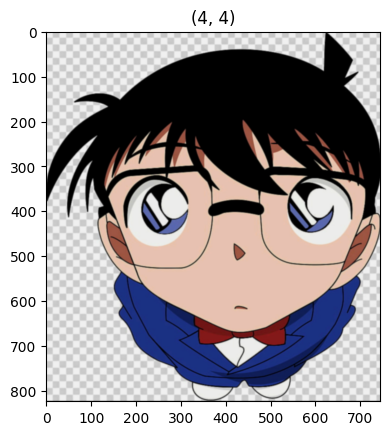

Block size:(8,8), Time processing on GPU with shared memory: 0.005754709243774414s


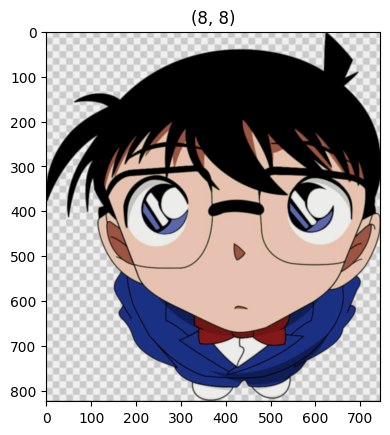

Block size:(16,16), Time processing on GPU with shared memory: 0.010295391082763672s


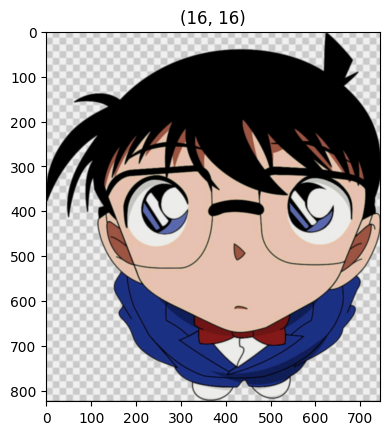

Block size:(32,32), Time processing on GPU with shared memory: 0.021712779998779297s


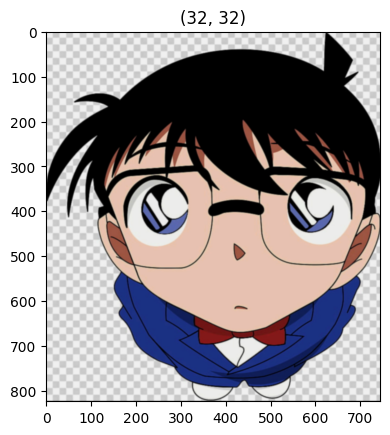

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Block size:(2,2), Time processing on GPU without shared memory: 0.5376944541931152s


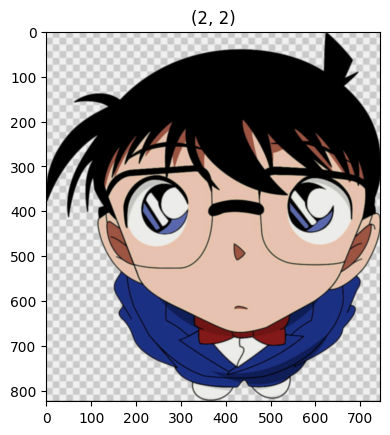

Block size:(4,4), Time processing on GPU without shared memory: 0.012284040451049805s


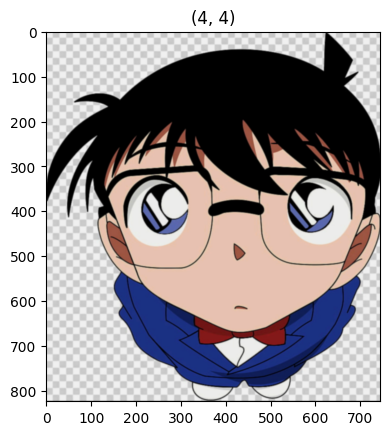

Block size:(8,8), Time processing on GPU without shared memory: 0.006086111068725586s


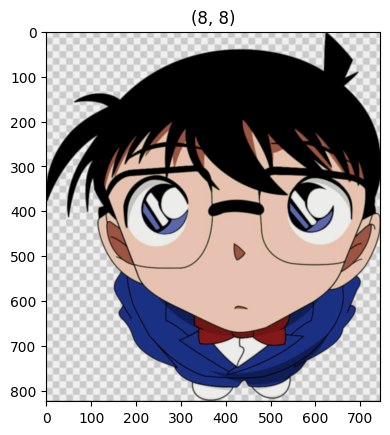

Block size:(16,16), Time processing on GPU without shared memory: 0.012275457382202148s


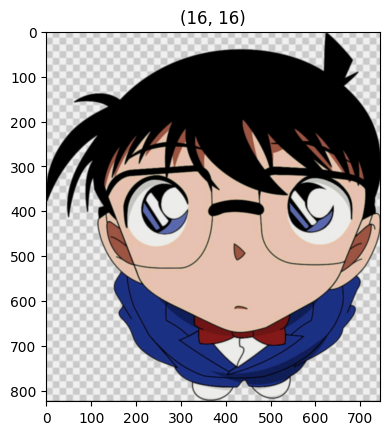

Block size:(32,32), Time processing on GPU without shared memory: 0.021180391311645508s


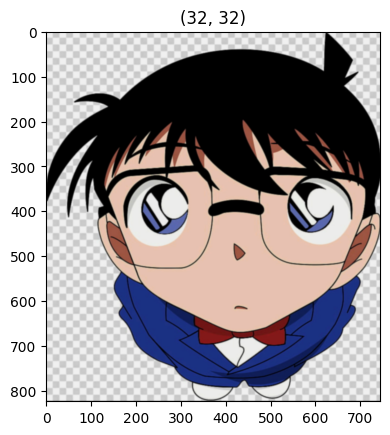

In [5]:

import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, types
from numba import jit
from matplotlib.image import imread
import math
import time

# Load an image from a file
image_path = 'labwork5-original.jpg'
image = imread(image_path)
plt.imshow(image), plt.title('Original')
plt.show()

# Get the image dimensions
image_height = image.shape[0]
image_width = image.shape[1]


# grayscale using GPU with 2D blocks without share memory
@cuda.jit
def gaussian_blur_convolution(src, dst, gk):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    count = 0
    r = 0.0
    g = 0.0
    b = 0.0
    for i in range(-3,4):
      if i + x < 0 or i + x >= src.shape[0]:
        continue
      for j in range(-3,4):
        if j + y < 0 or  j + y >= src.shape[1]:
          continue
        dst[x,y,0] += src[i + x,j + y, 0] * gk[i + 3,j + 3]
        dst[x,y,1] += src[i + x,j + y, 1] * gk[i + 3,j + 3]
        dst[x,y,2] += src[i + x,j + y, 2] * gk[i + 3,j + 3]

# grayscale using GPU with 2D blocks with share memory
@cuda.jit
def gaussian_blur_convolution_sm(src, dst, gk):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    shared_kernel = cuda.shared.array(shape=(7, 7), dtype=types.float32)
    if cuda.threadIdx.x < 7 and cuda.threadIdx.y < 7:
        shared_kernel[cuda.threadIdx.x, cuda.threadIdx.y] = gk[
            cuda.threadIdx.x, cuda.threadIdx.y
        ]

    cuda.syncthreads()

    count = 0
    r = 0.0
    g = 0.0
    b = 0.0
    for i in range(-3,4):
      if i + x < 0 or i + x >= src.shape[0]:
        continue
      for j in range(-3,4):
        if j + y < 0 or  j + y >= src.shape[1]:
          continue
        dst[x,y,0] += src[i + x,j + y, 0] * gk[i + 3,j + 3]
        dst[x,y,1] += src[i + x,j + y, 1] * gk[i + 3,j + 3]
        dst[x,y,2] += src[i + x,j + y, 2] * gk[i + 3,j + 3]


#Implement with GPU
blockSizes = [(2,2),(4,4),(8, 8),(16, 16),(32,32)]
times_gpu = []
gk = np.array(
    [
        [0, 0, 1, 2, 1, 0, 0],
        [0, 3, 13, 22, 13, 3, 0],
        [1, 13, 59, 97, 59, 13, 1],
        [2, 22, 97, 159, 97, 22, 2],
        [1, 13, 59, 97, 59, 13, 1],
        [0, 3, 13, 22, 13, 3, 0],
        [0, 0, 1, 2, 1, 0, 0],
    ],
    dtype=np.float32,
)
gk /= gk.sum()

# with share memory
for block_size in blockSizes:
  devSrc = cuda.to_device(image)
  devDst = cuda.device_array((image_height, image_width, 3), np.uint8)

  grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
  grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
  start_time_gpu = time.time()
  gaussian_blur_convolution_sm[(grid_size_x, grid_size_y), block_size](devSrc, devDst, gk)
  time_gpu = time.time() - start_time_gpu
  times_gpu.append(time_gpu)
  print(f"Block size:({block_size[0]},{block_size[1]}), Time processing on GPU with shared memory: {time_gpu}s")

  hostDst = devDst.copy_to_host()
  gaussian_blur_convolution_image = np.array(hostDst)
  plt.imsave(f'labwork5-gaussian_blur_convolution_sm_({block_size[0]},{block_size[1]}).jpg', gaussian_blur_convolution_image, cmap='gray')

  plt.title(block_size)
  plt.imshow(gaussian_blur_convolution_image)
  plt.show()

# without share memory
for block_size in blockSizes:
  devSrc = cuda.to_device(image)
  devDst = cuda.device_array((image_height, image_width, 3), np.uint8)

  grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
  grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
  start_time_gpu = time.time()
  gaussian_blur_convolution[(grid_size_x, grid_size_y), block_size](devSrc, devDst, gk)
  time_gpu = time.time() - start_time_gpu
  times_gpu.append(time_gpu)
  print(f"Block size:({block_size[0]},{block_size[1]}), Time processing on GPU without shared memory: {time_gpu}s")

  hostDst = devDst.copy_to_host()
  gaussian_blur_convolution_image = np.array(hostDst)
  plt.imsave(f'labwork5-gaussian_blur_convolution_({block_size[0]},{block_size[1]}).jpg', gaussian_blur_convolution_image, cmap='gray')

  plt.title(block_size)
  plt.imshow(gaussian_blur_convolution_image)
  plt.show()